In [1]:
# IMPORT SOME MODULES =========================================================================
%pylab inline

from matplotlib.mlab import griddata
import pyfits as pyf
from PyTools import flux, nbins, err, binner, binned_stat, integrated_flux
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import product
from string import join
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# CONFIG PLOTS ================================================================================
rc("patch", linewidth=1)
# labels --------------------------------------------------------------------------------------
par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]
res_lbs = [r"$\Delta_r M_\star$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
           r"$\Delta\left<\log{Z_\star}\right>_M$", r"$\Delta\left<\log{Z_\star}\right>_L$", r"$\Delta A_V$"]

tsize = "xx-small"

ssag_lb = r"\bf SSAG"
sdss_lb = r"\bf SDSS"
jpas_lb = r"\bf J-PAS"
spec_lb = r"\bf SPEC"

sfg_lb = r"\bf SFGs"
pag_lb = r"\bf PaGs"
sam_lb = r"\bf All Galaxies"

# colors --------------------------------------------------------------------------------------
hatching = "/"*15
gray = "0.3"
ssag_cl = "0.2"
sdss_cl = "#F6C141"
sdss_sg = [sdss_cl, "#E8601C"]
jpas_cl = "#90C987"
jpas_sg = [jpas_cl, "#4EB265"]
spec_cl = "#7BAFDE"
spec_sg = [spec_cl, "#1965B0"]
map_col = cm.viridis

# output dir ----------------------------------------------------------------------------------
od = os.path.expandvars("$HOME/Documents/Papers/photofit_near_paper/")

In [3]:
# LOAD DATA ===================================================================================
# angle distribution data ---------------------------------------------------------------------
allw_table = loadtxt("../outputs/tests/ssps_comp_all_wl_av1_Z2p5.txt")
sdss_table = loadtxt("../outputs/tests/ssps_comp_sdss_av1_Z2p5.txt")
jpas_table = loadtxt("../outputs/tests/ssps_comp_jpas_av1_Z2p5.txt")
spec_table = loadtxt("../outputs/tests/ssps_comp_spec_av1_Z2p5.txt")

allw_table[isnan(allw_table)] = 0.0
sdss_table[isnan(sdss_table)] = 0.0
jpas_table[isnan(jpas_table)] = 0.0
spec_table[isnan(spec_table)] = 0.0
# --------------------------------------------------------------------------------------------
# SFH/SED demonstration ----------------------------------------------------------------------
b = pyf.open("../inputs/SFHs_set3/56642.812154.fits.gz")
r = pyf.open("../inputs/SFHs_set3/56645.805769.fits.gz")

sdss_res = loadtxt("../inputs/SDSS_filters.txt")
jpas = open("../inputs/JPAS_filters.txt").readlines()

u_res = sdss_res[:47]
g_res = sdss_res[47:47+89]
r_res = sdss_res[47+89:47+89+75]
i_res = sdss_res[47+89+75:47+89+75+89]
z_res = sdss_res[47+89+75+89:]

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))

mag_nm = "umag gmag rmag imag zmag".split()
sdss_w = array([3.5618E+03, 4.7189E+03, 6.1852E+03, 7.4997E+03, 8.9615E+03])
jpas_w = array([3485, 3785, 3900, 4000] + range(4100, 9200,100) + [10075], dtype=float)
b_sdss = array([flux(b[0].header[mag_nm[i]], sdss_w[i]) for i in xrange(5)])
r_sdss = array([flux(r[0].header[mag_nm[i]], sdss_w[i]) for i in xrange(5)])
b_jpas = array([integrated_flux(column_stack((b[1].data["wavelength"], b[1].data["flux"])), filt) for filt in jpas_res])
r_jpas = array([integrated_flux(column_stack((r[1].data["wavelength"], r[1].data["flux"])), filt) for filt in jpas_res])
# --------------------------------------------------------------------------------------------
# sample demonstration data ------------------------------------------------------------------
name_phot = loadtxt("../inputs/set3_catalog.txt", usecols=(0,), dtype="|S")
name_spec = loadtxt("../outputs/spectroscopic_fit/names_v3s20m.txt", usecols=(0,), dtype="|S")
name_jpas = loadtxt("../inputs/photoz3/set3.equiv", dtype=str, usecols=(0, 2))[:120].repeat(50, axis=0)

sort_jp = lexsort((name_jpas[:, 0], name_jpas[:, 1]))
sort_ph = argsort(name_phot.repeat(50))
sort_sp = argsort(name_spec)
indexes = []
for i in xrange(120): indexes += range(i * 100, i * 100 + 50)

u_obs, g_obs, r_obs, i_obs, z_obs, redshift = loadtxt("../inputs/total_photometry.txt", usecols=range(1, 6) + [11], unpack=True)
u_lib, g_lib, r_lib, i_lib, z_lib, b4000_ssag, tt = loadtxt("../inputs/set3_catalog.txt", usecols=range(39, 39 + 5)+[32, 22])[argsort(name_phot)].T
tform, mass, mass_1gyr, Z = loadtxt("../inputs/set3_catalog.txt", usecols=(5, 16, 18, 12)).repeat(50, axis=0)[sort_ph].T
trun = loadtxt("../inputs/set3_catalog.txt", dtype=str, usecols=(9,)).repeat(50, axis=0)[sort_ph].T
trun = array([eval(t.title()) for t in trun])

zmask = redshift < 0.03
ocolor_x = (u_obs - g_obs)[zmask]
ocolor_y = (g_obs - r_obs)[zmask]
lcolor_x = (u_lib - g_lib)[log10(Z[::50])>=-0.4]
lcolor_y = (g_lib - r_lib)[log10(Z[::50])>=-0.4]
lcolor = (u_lib - r_lib).repeat(50)
mu = mass_1gyr / mass * 100.0
# --------------------------------------------------------------------------------------------
# main results data --------------------------------------------------------------------------
sdss_physical = genfromtxt("../outputs/photometric_fit/remote_set3/corr_photofit_SDSS.physical", dtype=None, names=True)[indexes][sort_ph]
jpas_physical = genfromtxt("../outputs/photometric_fit/photoz3/corr_photofit_z0p00.physical", dtype=None, names=True)[:6000][sort_jp]
spec_models = genfromtxt("../outputs/spectroscopic_fit/dynbas_table_v3s20m.txt", usecols=range(6), dtype=None, names=True)[sort_sp]

sdss_physical["Z_M_lib"] = log10(sdss_physical["Z_M_lib"])
sdss_physical["Z_M_mod"] = log10(sdss_physical["Z_M_mod"])
sdss_physical["Z_L_lib"] = log10(sdss_physical["Z_L_lib"])
sdss_physical["Z_L_mod"] = log10(sdss_physical["Z_L_mod"])
jpas_physical["Z_M_lib"] = log10(jpas_physical["Z_M_lib"])
jpas_physical["Z_M_mod"] = log10(jpas_physical["Z_M_mod"])
jpas_physical["Z_L_lib"] = log10(jpas_physical["Z_L_lib"])
jpas_physical["Z_L_mod"] = log10(jpas_physical["Z_L_mod"])

names_list = join(sdss_physical.dtype.names).replace("Z", "log_Z").split()
sdss_physical.dtype.names = names_list
jpas_physical.dtype.names = names_list

spec_physical = zeros(sdss_physical.shape, dtype=zip(names_list, [np.float32]*len(names_list)))
for l, m in zip(names_list[0::2], names_list[1::2]):
    spec_physical[l] = sdss_physical[l]
    spec_physical[m] = spec_models[m]
# ---------------------------------------------------------------------------------------------
# remove crap ---------------------------------------------------------------------------------
mask = (jpas_physical["log_t_M_mod"] <= log10(13.75e9))&(jpas_physical["log_Z_M_lib"] >= -0.4)&(~trun)

sdss_physical = sdss_physical[mask]
jpas_physical = jpas_physical[mask]
spec_physical = spec_physical[mask]

lcolor = lcolor[mask]
mu = mu[mask]
mass_1gyr = mass_1gyr[mask]
mass = mass[mask]
tform = tform[mask]
# ---------------------------------------------------------------------------------------------
# define keys ---------------------------------------------------------------------------------
ln = names_list[0::2]
mn = names_list[1::2]
rl = [True] + [False] * (len(ln)-1)

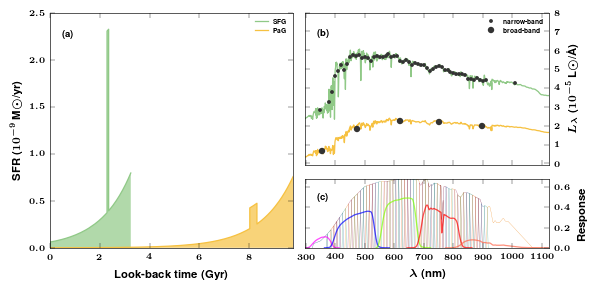

In [4]:
figure(figsize=(7, 3.3))

ax1 = subplot2grid((3,2), (0,0), rowspan=3)
ax2 = subplot2grid((3,2), (0,1), rowspan=2)
ax3 = subplot2grid((3,2), (2,1))

fc = 2.5
today = max(b[2].data["age"].max(), r[2].data["age"].max()) / 1e9

ax1.set_xlim(0.0, today)
ax1.set_ylim(0.0, 2.5)
ax1.set_ylabel(r"\bf SFR ($10^{-9}\,$M$\odot$/yr)")
ax1.set_xlabel(r"\bf Look-back time (Gyr)")
ax1.text(0.05, 0.90, r"\bf (a)", fontsize="small", ha="left", transform=ax1.transAxes)

ax1.plot(b[2].data["age"].max()/1e9 - b[2].data["age"]/1e9, b[2].data["sfr"]/1e-9, "-",
         color=jpas_cl, label=r"\bf SFG")
ax1.fill_between(b[2].data["age"].max()/1e9 - b[2].data["age"]/1e9, b[2].data["sfr"]/1e-9,
                 color=jpas_cl, lw=0, alpha=0.7)
ax1.plot(r[2].data["age"].max()/1e9 - r[2].data["age"]/1e9, r[2].data["sfr"]/1e-9, "-",
         color=sdss_cl, label=r"\bf PaG")
ax1.fill_between(r[2].data["age"].max()/1e9 - r[2].data["age"]/1e9, r[2].data["sfr"]/1e-9,
                 color=sdss_cl, lw=0, alpha=0.7)
ax1.legend(loc=0)

ax2.tick_params(labelleft=False, labelright=True, labelbottom=False)
ax2.yaxis.set_label_position("right")
ax2.set_xlim((sdss_res[:, 0]/10).min(), (sdss_res[:, 0]/10).max())
ax2.set_ylim(-0.07, 8)
ax2.set_ylabel(r"\bf $L_\lambda$ ($10^{-5}\,$L$\odot$/\AA)")
ax2.text(0.05, 0.85, r"\bf (b)", fontsize="small", ha="left", transform=ax2.transAxes)

ax2.plot(b[1].data["wavelength"]/10, b[1].data["flux"]/1e-5, "-", color=jpas_cl)
ax2.plot(r[1].data["wavelength"]/10, r[1].data["flux"]/1e-5, "-", color=sdss_cl)
ax2.plot(jpas_w/10, b_jpas / 1e-5, "o", ms=3, mec="none", mfc=ssag_cl, label=r"\bf narrow-band")
ax2.plot(sdss_w/10, r_sdss*4*pi*3.09e19/3.846e33*3.09e19/1e-5, "o", ms=5, mec="none", mfc=ssag_cl, label=r"\bf broad-band")
ax2.legend(loc=1)

ax3.tick_params(labelleft=False, labelright=True)
ax3.yaxis.set_label_position("right")
ax3.set_xlim((sdss_res[:, 0]/10).min(), (sdss_res[:, 0]/10).max())
ax3.set_yticks(arange(0.0, 0.7, 0.2))
ax3.set_xlabel(r"\bf $\lambda$ (nm)")
ax3.set_ylabel(r"\bf Response")
ax3.text(0.05, 0.70, r"\bf (c)", fontsize="small", ha="left", transform=ax3.transAxes)

for filt in jpas_res: ax3.plot(filt[:, 0]/10, filt[:, 1], "-", lw=0.2)
ax3.plot(u_res[:, 0]/10, u_res[:, 1], "-", color="fuchsia", alpha=0.7)
ax3.plot(g_res[:, 0]/10, g_res[:, 1], "-", color="blue", alpha=0.7)
ax3.plot(r_res[:, 0]/10, r_res[:, 1], "-", color="chartreuse", alpha=0.7)
ax3.plot(i_res[:, 0]/10, i_res[:, 1], "-", color="red", alpha=0.7)
ax3.plot(z_res[:, 0]/10, z_res[:, 1], "-", color="tomato", alpha=0.7)

subplots_adjust(wspace=0.05)
savefig(od + "SFH_demonstration")

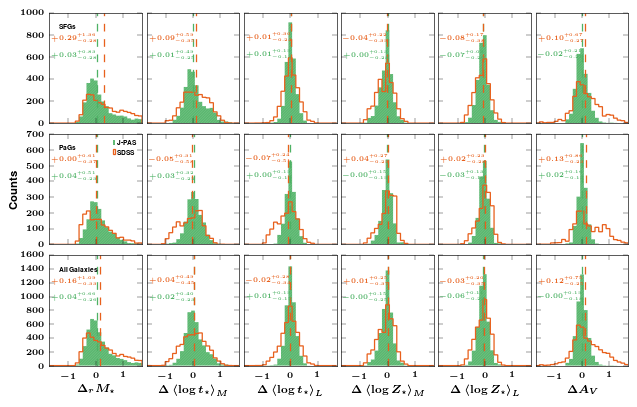

In [5]:
fig, axs = subplots(3, len(ln), figsize=(7, 4.5), sharex=True, sharey="row")

lm = xlim(-1.7, +1.7)
axs[0, 0].set_xticks([-1, 0, 1])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])) :
    if   i == 0 :
        mask = lcolor <  2.22
    elif i == 1 :
        mask = lcolor >= 2.22
        
        if j == 0 : axs[i, j].set_ylabel(r"\bf Counts")
    else :
        mask = ones(lcolor.size, dtype=bool)
        
        axs[i, j].set_xlabel(res_lbs[j])

    ress = err(sdss_physical[ln[j]], sdss_physical[mn[j]], rl[j])[mask]
    meds = median(ress)
    p16s, p84s = percentile(ress, [16.0, 84.0])
    
    resj = err(jpas_physical[ln[j]], jpas_physical[mn[j]], rl[j])[mask]
    medj = median(resj)
    p16j, p84j = percentile(resj, [16.0, 84.0])

    axs[i, j].hist(resj, 25, histtype="step", hatch=hatching, lw=0, color=jpas_sg[1], range=lm, label=jpas_lb)
    axs[i, j].hist(ress, 25, histtype="step", color=sdss_sg[1], range=lm, label=sdss_lb)

    axs[i, j].axvline(medj, ls="--", color=jpas_sg[1])
    axs[i, j].axvline(meds, ls="--", color=sdss_sg[1])

    st_texts = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (meds, p16s, p84s)
    st_textj = r"\bf $%+.2f_{%+.2f}^{%+.2f}$" % (medj, p16j, p84j)
    axs[i, j].text(0.02, 0.75, st_texts, fontsize=tsize, color=sdss_sg[1], ha="left", transform=axs[i, j].transAxes)
    axs[i, j].text(0.02, 0.60, st_textj, fontsize=tsize, color=jpas_sg[1], ha="left", transform=axs[i, j].transAxes)

    if j == 0 :
        if i == 0 : axs[i, j].text(0.1, 0.9, sfg_lb, fontsize=tsize, ha="left", va="top", transform=axs[i, j].transAxes)
        if i == 1 : axs[i, j].text(0.1, 0.9, pag_lb, fontsize=tsize, ha="left", va="top", transform=axs[i, j].transAxes)
        if i == 2 : axs[i, j].text(0.1, 0.9, sam_lb, fontsize=tsize, ha="left", va="top", transform=axs[i, j].transAxes)

axs[1, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(hspace=0.1, wspace=0.05)

savefig(od + "SDSS_vs_JPAS")

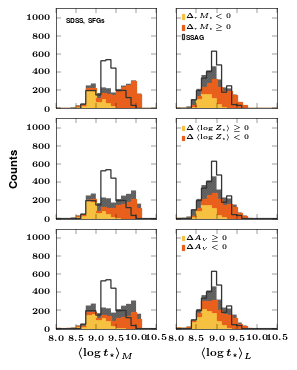

In [6]:
fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

ylim(0, 1100)

dm = err(sdss_physical["M_lib"], sdss_physical["M_mod"], True)
dtm = err(sdss_physical["log_t_M_lib"], sdss_physical["log_t_M_mod"], False)
dtl = err(sdss_physical["log_t_L_lib"], sdss_physical["log_t_L_mod"], False)
dZm = err(sdss_physical["log_Z_M_lib"], sdss_physical["log_Z_M_mod"], False)
dZl = err(sdss_physical["log_Z_L_lib"], sdss_physical["log_Z_L_mod"], False)
dAv = err(sdss_physical["Av_lib"], sdss_physical["Av_mod"], False)

mask = lcolor < 2.22

m = (dm < 0.0)&(dtm < 0.0)
n = (dm >=0.0)&(dtm >=0.0)

axs[0, 0].hist(sdss_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 0].hist([sdss_physical["log_t_M_mod"][mask&m], sdss_physical["log_t_M_mod"][mask&n]],
                            20, histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[0, 0].hist(sdss_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 0].text(0.1, 0.9, join([sdss_lb, sfg_lb], ", "), fontsize=tsize, ha="left", va="top", transform=axs[0, 0].transAxes)

m = (dm < 0.0)&(dtl < 0.0)
n = (dm >=0.0)&(dtl >=0.0)

axs[0, 1].hist(sdss_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 1].hist([sdss_physical["log_t_L_mod"][mask&m], sdss_physical["log_t_L_mod"][mask&n]],
                            20, histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1,
                            label=[r"$\Delta_r M_\star<0\,$", r"$\Delta_r M_\star\ge0\,$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[0, 1].hist(sdss_physical["log_t_L_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dZm >=0.0)&(dtm < 0.0)
n = (dZm < 0.0)&(dtm >=0.0)

axs[1, 0].hist(sdss_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 0].hist([sdss_physical["log_t_M_mod"][mask&m], sdss_physical["log_t_M_mod"][mask&n]],
                            20, histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[1, 0].hist(sdss_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[1, 0].set_ylabel(r"\bf Counts")

m = (dZl >=0.0)&(dtl < 0.0)
n = (dZl < 0.0)&(dtl >=0.0)

axs[1, 1].hist(sdss_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 1].hist([sdss_physical["log_t_L_mod"][mask&m], sdss_physical["log_t_L_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta\left<\log Z_\star\right>\ge0$", r"$\Delta\left<\log Z_\star\right><0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[1, 1].hist(sdss_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[1, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dAv >=0.0)&(dtm < 0.0)
n = (dAv < 0.0)&(dtm >=0.0)

axs[2, 0].hist(sdss_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 0].hist([sdss_physical["log_t_M_mod"][mask&m], sdss_physical["log_t_M_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[2, 0].hist(sdss_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[2, 0].set_xlabel(par_lbs[1])

m = (dAv >=0.0)&(dtl < 0.0)
n = (dAv < 0.0)&(dtl >=0.0)

axs[2, 1].hist(sdss_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 1].hist([sdss_physical["log_t_L_mod"][mask&m], sdss_physical["log_t_L_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta A_V\ge0$", r"$\Delta A_V<0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[2, 1].hist(sdss_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[2, 1].set_xlabel(par_lbs[2])
axs[2, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig(od + "age_vs_mass-metallicity-extinction_trends_sdss_sfg")

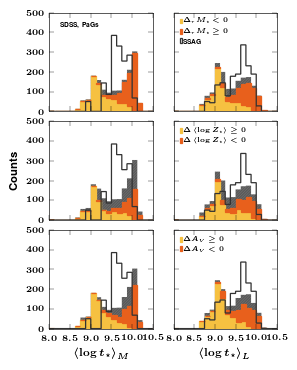

In [7]:
fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

ylim(0, 500)

dm = err(sdss_physical["M_lib"], sdss_physical["M_mod"], True)
dtm = err(sdss_physical["log_t_M_lib"], sdss_physical["log_t_M_mod"], False)
dtl = err(sdss_physical["log_t_L_lib"], sdss_physical["log_t_L_mod"], False)
dZm = err(sdss_physical["log_Z_M_lib"], sdss_physical["log_Z_M_mod"], False)
dZl = err(sdss_physical["log_Z_L_lib"], sdss_physical["log_Z_L_mod"], False)
dAv = err(sdss_physical["Av_lib"], sdss_physical["Av_mod"], False)

mask = lcolor >= 2.22

m = (dm < 0.0)&(dtm < 0.0)
n = (dm >=0.0)&(dtm >=0.0)

axs[0, 0].hist(sdss_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 0].hist([sdss_physical["log_t_M_mod"][mask&m], sdss_physical["log_t_M_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[0, 0].hist(sdss_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 0].text(0.1, 0.9, join([sdss_lb, pag_lb], ", "), fontsize=tsize, ha="left", va="top",
               transform=axs[0, 0].transAxes)

m = (dm < 0.0)&(dtl < 0.0)
n = (dm >=0.0)&(dtl >=0.0)

axs[0, 1].hist(sdss_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 1].hist([sdss_physical["log_t_L_mod"][mask&m], sdss_physical["log_t_L_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1,
                            label=[r"$\Delta_r M_\star<0\,$", r"$\Delta_r M_\star\ge0\,$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[0, 1].hist(sdss_physical["log_t_L_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dZm >=0.0)&(dtm < 0.0)
n = (dZm < 0.0)&(dtm >=0.0)

axs[1, 0].hist(sdss_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 0].hist([sdss_physical["log_t_M_mod"][mask&m], sdss_physical["log_t_M_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[1, 0].hist(sdss_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[1, 0].set_ylabel(r"\bf Counts")

m = (dZl >=0.0)&(dtl < 0.0)
n = (dZl < 0.0)&(dtl >=0.0)

axs[1, 1].hist(sdss_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 1].hist([sdss_physical["log_t_L_mod"][mask&m], sdss_physical["log_t_L_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta\left<\log Z_\star\right>\ge0$",
                                   r"$\Delta\left<\log Z_\star\right><0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[1, 1].hist(sdss_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[1, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dAv >=0.0)&(dtm < 0.0)
n = (dAv < 0.0)&(dtm >=0.0)

axs[2, 0].hist(sdss_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 0].hist([sdss_physical["log_t_M_mod"][mask&m], sdss_physical["log_t_M_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[2, 0].hist(sdss_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[2, 0].set_xlabel(par_lbs[1])

m = (dAv >=0.0)&(dtl < 0.0)
n = (dAv < 0.0)&(dtl >=0.0)

axs[2, 1].hist(sdss_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 1].hist([sdss_physical["log_t_L_mod"][mask&m], sdss_physical["log_t_L_mod"][mask&n]], 20,
                            histtype="barstacked", color=sdss_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta A_V\ge0$", r"$\Delta A_V<0$"])

ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(sdss_sg[0])
    p2.set_edgecolor(sdss_sg[1])
axs[2, 1].hist(sdss_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[2, 1].set_xlabel(par_lbs[2])
axs[2, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig(od + "age_vs_mass-metallicity-extinction_trends_sdss_pag")

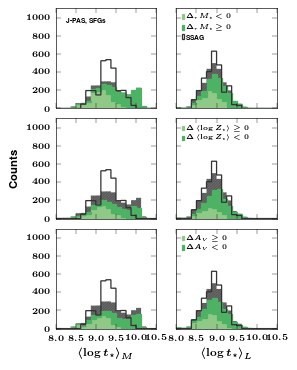

In [8]:
fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

ylim(0, 1100)

dm = err(jpas_physical["M_lib"], jpas_physical["M_mod"], True)
dtm = err(jpas_physical["log_t_M_lib"], jpas_physical["log_t_M_mod"], False)
dtl = err(jpas_physical["log_t_L_lib"], jpas_physical["log_t_L_mod"], False)
dZm = err(jpas_physical["log_Z_M_lib"], jpas_physical["log_Z_M_mod"], False)
dZl = err(jpas_physical["log_Z_L_lib"], jpas_physical["log_Z_L_mod"], False)
dAv = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)

mask = lcolor < 2.22

m = (dm < 0.0)&(dtm < 0.0)
n = (dm >=0.0)&(dtm >=0.0)

axs[0, 0].hist(jpas_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 0].hist([jpas_physical["log_t_M_mod"][mask&m], jpas_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[0, 0].hist(jpas_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 0].text(0.1, 0.9, join([jpas_lb, sfg_lb], ", "), fontsize=tsize, ha="left", va="top", transform=axs[0, 0].transAxes)

m = (dm < 0.0)&(dtl < 0.0)
n = (dm >=0.0)&(dtl >=0.0)

axs[0, 1].hist(jpas_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 1].hist([jpas_physical["log_t_L_mod"][mask&m], jpas_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1, label=[r"$\Delta_r M_\star<0\,$", r"$\Delta_r M_\star\ge0\,$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[0, 1].hist(jpas_physical["log_t_L_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dZm >=0.0)&(dtm < 0.0)
n = (dZm < 0.0)&(dtm >=0.0)

axs[1, 0].hist(jpas_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 0].hist([jpas_physical["log_t_M_mod"][mask&m], jpas_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[1, 0].hist(jpas_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[1, 0].set_ylabel(r"\bf Counts")

m = (dZl >=0.0)&(dtl < 0.0)
n = (dZl < 0.0)&(dtl >=0.0)

axs[1, 1].hist(jpas_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 1].hist([jpas_physical["log_t_L_mod"][mask&m], jpas_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta\left<\log Z_\star\right>\ge0$", r"$\Delta\left<\log Z_\star\right><0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[1, 1].hist(jpas_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[1, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dAv >=0.0)&(dtm < 0.0)
n = (dAv < 0.0)&(dtm >=0.0)

axs[2, 0].hist(jpas_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 0].hist([jpas_physical["log_t_M_mod"][mask&m], jpas_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[2, 0].hist(jpas_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[2, 0].set_xlabel(par_lbs[1])

m = (dAv >=0.0)&(dtl < 0.0)
n = (dAv < 0.0)&(dtl >=0.0)

axs[2, 1].hist(jpas_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 1].hist([jpas_physical["log_t_L_mod"][mask&m], jpas_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0, label=[r"$\Delta A_V\ge0$", r"$\Delta A_V<0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[2, 1].hist(jpas_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[2, 1].set_xlabel(par_lbs[2])
axs[2, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig(od + "age_vs_mass-metallicity-extinction_trends_jpas_sfg")

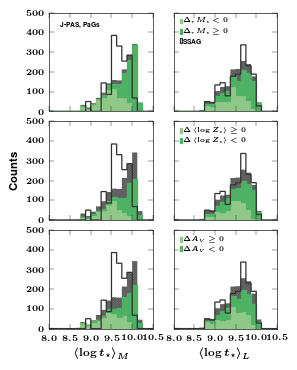

In [9]:
fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

ylim(0, 500)

dm = err(jpas_physical["M_lib"], jpas_physical["M_mod"], True)
dtm = err(jpas_physical["log_t_M_lib"], jpas_physical["log_t_M_mod"], False)
dtl = err(jpas_physical["log_t_L_lib"], jpas_physical["log_t_L_mod"], False)
dZm = err(jpas_physical["log_Z_M_lib"], jpas_physical["log_Z_M_mod"], False)
dZl = err(jpas_physical["log_Z_L_lib"], jpas_physical["log_Z_L_mod"], False)
dAv = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)

mask = lcolor >= 2.22

m = (dm < 0.0)&(dtm < 0.0)
n = (dm >=0.0)&(dtm >=0.0)

axs[0, 0].hist(jpas_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 0].hist([jpas_physical["log_t_M_mod"][mask&m], jpas_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[0, 0].hist(jpas_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 0].text(0.1, 0.9, join([jpas_lb, pag_lb], ", "), fontsize=tsize, ha="left", va="top", transform=axs[0, 0].transAxes)

m = (dm < 0.0)&(dtl < 0.0)
n = (dm >=0.0)&(dtl >=0.0)

axs[0, 1].hist(jpas_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 1].hist([jpas_physical["log_t_L_mod"][mask&m], jpas_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1, label=[r"$\Delta_r M_\star<0\,$", r"$\Delta_r M_\star\ge0\,$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[0, 1].hist(jpas_physical["log_t_L_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dZm >=0.0)&(dtm < 0.0)
n = (dZm < 0.0)&(dtm >=0.0)

axs[1, 0].hist(jpas_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 0].hist([jpas_physical["log_t_M_mod"][mask&m], jpas_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[1, 0].hist(jpas_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[1, 0].set_ylabel(r"\bf Counts")

m = (dZl >=0.0)&(dtl < 0.0)
n = (dZl < 0.0)&(dtl >=0.0)

axs[1, 1].hist(jpas_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 1].hist([jpas_physical["log_t_L_mod"][mask&m], jpas_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta\left<\log Z_\star\right>\ge0$", r"$\Delta\left<\log Z_\star\right><0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[1, 1].hist(jpas_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[1, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dAv >=0.0)&(dtm < 0.0)
n = (dAv < 0.0)&(dtm >=0.0)

axs[2, 0].hist(jpas_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 0].hist([jpas_physical["log_t_M_mod"][mask&m], jpas_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[2, 0].hist(jpas_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[2, 0].set_xlabel(par_lbs[1])

m = (dAv >=0.0)&(dtl < 0.0)
n = (dAv < 0.0)&(dtl >=0.0)

axs[2, 1].hist(jpas_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 1].hist([jpas_physical["log_t_L_mod"][mask&m], jpas_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=jpas_sg, ec="none", range=(8, 10.5), rwidth=1.0, label=[r"$\Delta A_V\ge0$", r"$\Delta A_V<0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(jpas_sg[0])
    p2.set_edgecolor(jpas_sg[1])
axs[2, 1].hist(jpas_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[2, 1].set_xlabel(par_lbs[2])
axs[2, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig(od + "age_vs_mass-metallicity-extinction_trends_jpas_pag")

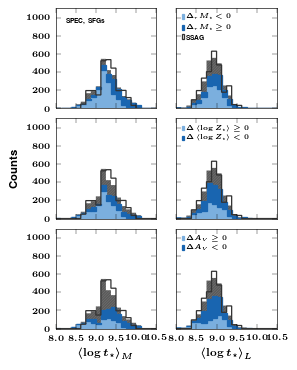

In [10]:
fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

ylim(0, 1100)

dm = err(spec_physical["M_lib"], spec_physical["M_mod"], True)
dtm = err(spec_physical["log_t_M_lib"], spec_physical["log_t_M_mod"], False)
dtl = err(spec_physical["log_t_L_lib"], spec_physical["log_t_L_mod"], False)
dZm = err(spec_physical["log_Z_M_lib"], spec_physical["log_Z_M_mod"], False)
dZl = err(spec_physical["log_Z_L_lib"], spec_physical["log_Z_L_mod"], False)
dAv = err(spec_physical["Av_lib"], spec_physical["Av_mod"], False)

mask = lcolor < 2.22

m = (dm < 0.0)&(dtm < 0.0)
n = (dm >=0.0)&(dtm >=0.0)

axs[0, 0].hist(spec_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 0].hist([spec_physical["log_t_M_mod"][mask&m], spec_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[0, 0].hist(spec_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 0].text(0.1, 0.9, join([spec_lb, sfg_lb], ", "), fontsize=tsize, ha="left", va="top", transform=axs[0, 0].transAxes)

m = (dm < 0.0)&(dtl < 0.0)
n = (dm >=0.0)&(dtl >=0.0)

axs[0, 1].hist(spec_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 1].hist([spec_physical["log_t_L_mod"][mask&m], spec_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1, label=[r"$\Delta_r M_\star<0\,$", r"$\Delta_r M_\star\ge0\,$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[0, 1].hist(spec_physical["log_t_L_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dZm >=0.0)&(dtm < 0.0)
n = (dZm < 0.0)&(dtm >=0.0)

axs[1, 0].hist(spec_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 0].hist([spec_physical["log_t_M_mod"][mask&m], spec_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[1, 0].hist(spec_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[1, 0].set_ylabel(r"\bf Counts")

m = (dZl >=0.0)&(dtl < 0.0)
n = (dZl < 0.0)&(dtl >=0.0)

axs[1, 1].hist(spec_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 1].hist([spec_physical["log_t_L_mod"][mask&m], spec_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta\left<\log Z_\star\right>\ge0$", r"$\Delta\left<\log Z_\star\right><0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[1, 1].hist(spec_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[1, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dAv >=0.0)&(dtm < 0.0)
n = (dAv < 0.0)&(dtm >=0.0)

axs[2, 0].hist(spec_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 0].hist([spec_physical["log_t_M_mod"][mask&m], spec_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[2, 0].hist(spec_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[2, 0].set_xlabel(par_lbs[1])

m = (dAv >=0.0)&(dtl < 0.0)
n = (dAv < 0.0)&(dtl >=0.0)

axs[2, 1].hist(spec_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 1].hist([spec_physical["log_t_L_mod"][mask&m], spec_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0, label=[r"$\Delta A_V\ge0$", r"$\Delta A_V<0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[2, 1].hist(spec_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[2, 1].set_xlabel(par_lbs[2])
axs[2, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig(od + "age_vs_mass-metallicity-extinction_trends_spec_sfg")

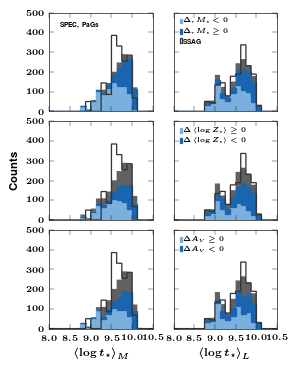

In [11]:
fig, axs = subplots(3, 2, figsize=(3.3, 4.1), sharex=True, sharey=True)

ylim(0, 500)

dm = err(spec_physical["M_lib"], spec_physical["M_mod"], True)
dtm = err(spec_physical["log_t_M_lib"], spec_physical["log_t_M_mod"], False)
dtl = err(spec_physical["log_t_L_lib"], spec_physical["log_t_L_mod"], False)
dZm = err(spec_physical["log_Z_M_lib"], spec_physical["log_Z_M_mod"], False)
dZl = err(spec_physical["log_Z_L_lib"], spec_physical["log_Z_L_mod"], False)
dAv = err(spec_physical["Av_lib"], spec_physical["Av_mod"], False)

mask = lcolor >= 2.22

m = (dm < 0.0)&(dtm < 0.0)
n = (dm >=0.0)&(dtm >=0.0)

axs[0, 0].hist(spec_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 0].hist([spec_physical["log_t_M_mod"][mask&m], spec_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[0, 0].hist(spec_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 0].text(0.1, 0.9, join([spec_lb, pag_lb], ", "), fontsize=tsize, ha="left", va="top", transform=axs[0, 0].transAxes)

m = (dm < 0.0)&(dtl < 0.0)
n = (dm >=0.0)&(dtl >=0.0)

axs[0, 1].hist(spec_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[0, 1].hist([spec_physical["log_t_L_mod"][mask&m], spec_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1, label=[r"$\Delta_r M_\star<0\,$", r"$\Delta_r M_\star\ge0\,$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[0, 1].hist(spec_physical["log_t_L_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5), label=ssag_lb)
axs[0, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dZm >=0.0)&(dtm < 0.0)
n = (dZm < 0.0)&(dtm >=0.0)

axs[1, 0].hist(spec_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 0].hist([spec_physical["log_t_M_mod"][mask&m], spec_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[1, 0].hist(spec_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[1, 0].set_ylabel(r"\bf Counts")

m = (dZl >=0.0)&(dtl < 0.0)
n = (dZl < 0.0)&(dtl >=0.0)

axs[1, 1].hist(spec_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[1, 1].hist([spec_physical["log_t_L_mod"][mask&m], spec_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0,
                            label=[r"$\Delta\left<\log Z_\star\right>\ge0$", r"$\Delta\left<\log Z_\star\right><0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[1, 1].hist(spec_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[1, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

m = (dAv >=0.0)&(dtm < 0.0)
n = (dAv < 0.0)&(dtm >=0.0)

axs[2, 0].hist(spec_physical["log_t_M_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 0].hist([spec_physical["log_t_M_mod"][mask&m], spec_physical["log_t_M_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0)
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[2, 0].hist(spec_physical["log_t_M_lib"][mask], 20, histtype="step", ec=ssag_cl, range=(8, 10.5))
axs[2, 0].set_xlabel(par_lbs[1])

m = (dAv >=0.0)&(dtl < 0.0)
n = (dAv < 0.0)&(dtl >=0.0)

axs[2, 1].hist(spec_physical["log_t_L_mod"][mask], 20, histtype="step", hatch=hatching, color=gray, lw=0, range=(8, 10.5))
ns, ib, ps = axs[2, 1].hist([spec_physical["log_t_L_mod"][mask&m], spec_physical["log_t_L_mod"][mask&n]], 20, histtype="barstacked",
                            color=spec_sg, ec="none", range=(8, 10.5), rwidth=1.0, label=[r"$\Delta A_V\ge0$", r"$\Delta A_V<0$"])
ps1, ps2 = ps
for p1, p2 in zip(ps1, ps2):
    p1.set_edgecolor(spec_sg[0])
    p2.set_edgecolor(spec_sg[1])
axs[2, 1].hist(spec_physical["log_t_L_lib"][mask], 20, histtype="step", color=ssag_cl, range=(8, 10.5))
axs[2, 1].set_xlabel(par_lbs[2])
axs[2, 1].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.2, hspace=0.1)
savefig(od + "age_vs_mass-metallicity-extinction_trends_spec_pag")

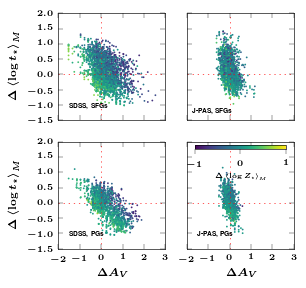

In [12]:
fig, axs = subplots(2, 2, figsize=(3.3, 3.3), sharex=True, sharey=True)

xlim(-2, +3)
ylim(-1.5, +2.0)

ins = inset_axes(axs[1, 1], width="85%", height="4%", loc=9)

dt = err(sdss_physical["log_t_M_lib"], sdss_physical["log_t_M_mod"], False)
dz = err(sdss_physical["log_Z_M_lib"], sdss_physical["log_Z_M_mod"], False)
dAv = err(sdss_physical["Av_lib"], sdss_physical["Av_mod"], False)

mask = lcolor < 2.22

ct = axs[0, 0].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[0, 0].axvline(ls=":", color="r", lw=0.5)
axs[0, 0].axhline(ls=":", color="r", lw=0.5)
axs[0, 0].text(0.1, 0.1, sdss_lb + ", SFGs", fontsize=tsize, ha="left", va="bottom", transform=axs[0, 0].transAxes)
axs[0, 0].set_ylabel(res_lbs[1])

mask = lcolor >=2.22

ct = axs[1, 0].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[1, 0].axvline(ls=":", color="r", lw=0.5)
axs[1, 0].axhline(ls=":", color="r", lw=0.5)
axs[1, 0].text(0.1, 0.1, sdss_lb + ", PGs", fontsize=tsize, ha="left", va="bottom", transform=axs[1, 0].transAxes)
axs[1, 0].set_xlabel(res_lbs[-1])
axs[1, 0].set_ylabel(res_lbs[1])

dt = err(jpas_physical["log_t_M_lib"], jpas_physical["log_t_M_mod"], False)
dz = err(jpas_physical["log_Z_M_lib"], jpas_physical["log_Z_M_mod"], False)
dAv = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)

mask = lcolor < 2.22

ct = axs[0, 1].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[0, 1].axvline(ls=":", color="r", lw=0.5)
axs[0, 1].axhline(ls=":", color="r", lw=0.5)
axs[0, 1].text(0.05, 0.05, jpas_lb + ", SFGs", fontsize=tsize, ha="left", va="bottom", transform=axs[0, 1].transAxes)

mask = lcolor >=2.22

ct = axs[1, 1].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[1, 1].axvline(ls=":", color="r", lw=0.5)
axs[1, 1].axhline(ls=":", color="r", lw=0.5)
axs[1, 1].text(0.1, 0.1, jpas_lb + ", PGs", fontsize=tsize, ha="left", va="bottom", transform=axs[1, 1].transAxes)
axs[1, 1].set_xlabel(res_lbs[-1])

cb = colorbar(ct, cax=ins, orientation="horizontal")
cb.set_ticks(linspace(-1., +1., 3))
cb.set_label(res_lbs[-3], fontsize=tsize)
ins.tick_params(top=False, bottom=True, direction="out")

savefig(od + "age-extinction-metallicity_mw_trends")

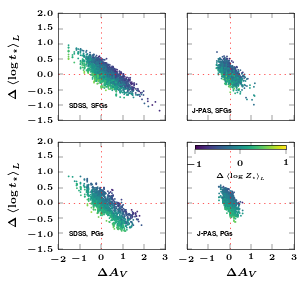

In [13]:
fig, axs = subplots(2, 2, figsize=(3.3, 3.3), sharex=True, sharey=True)

xlim(-2, +3)
ylim(-1.5, +2.0)

ins = inset_axes(axs[1, 1], width="85%", height="4%", loc=9)

dt = err(sdss_physical["log_t_L_lib"], sdss_physical["log_t_L_mod"], False)
dz = err(sdss_physical["log_Z_L_lib"], sdss_physical["log_Z_L_mod"], False)
dAv = err(sdss_physical["Av_lib"], sdss_physical["Av_mod"], False)

mask = lcolor < 2.22

ct = axs[0, 0].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[0, 0].axvline(ls=":", color="r", lw=0.5)
axs[0, 0].axhline(ls=":", color="r", lw=0.5)
axs[0, 0].text(0.1, 0.1, sdss_lb + ", SFGs", fontsize=tsize, ha="left", va="bottom", transform=axs[0, 0].transAxes)
axs[0, 0].set_ylabel(res_lbs[2])

mask = lcolor >=2.22

ct = axs[1, 0].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[1, 0].axvline(ls=":", color="r", lw=0.5)
axs[1, 0].axhline(ls=":", color="r", lw=0.5)
axs[1, 0].text(0.1, 0.1, sdss_lb + ", PGs", fontsize=tsize, ha="left", va="bottom", transform=axs[1, 0].transAxes)
axs[1, 0].set_xlabel(res_lbs[-1])
axs[1, 0].set_ylabel(res_lbs[2])

dt = err(jpas_physical["log_t_L_lib"], jpas_physical["log_t_L_mod"], False)
dz = err(jpas_physical["log_Z_L_lib"], jpas_physical["log_Z_L_mod"], False)
dAv = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)

mask = lcolor < 2.22

ct = axs[0, 1].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[0, 1].axvline(ls=":", color="r", lw=0.5)
axs[0, 1].axhline(ls=":", color="r", lw=0.5)
axs[0, 1].text(0.05, 0.05, jpas_lb + ", SFGs", fontsize=tsize, ha="left", va="bottom", transform=axs[0, 1].transAxes)

mask = lcolor >=2.22

ct = axs[1, 1].scatter(dAv[mask], dt[mask], c=dz[mask], s=2, edgecolor="none", vmin=-1.0, vmax=+1.0, cmap=map_col)
axs[1, 1].axvline(ls=":", color="r", lw=0.5)
axs[1, 1].axhline(ls=":", color="r", lw=0.5)
axs[1, 1].text(0.1, 0.1, jpas_lb + ", PGs", fontsize=tsize, ha="left", va="bottom", transform=axs[1, 1].transAxes)
axs[1, 1].set_xlabel(res_lbs[-1])

cb = colorbar(ct, cax=ins, orientation="horizontal")
cb.set_ticks(linspace(-1., +1., 3))
cb.set_label(res_lbs[-2], fontsize=tsize)
ins.tick_params(top=False, bottom=True, direction="out")

savefig(od + "age-extinction-metallicity_lw_trends")

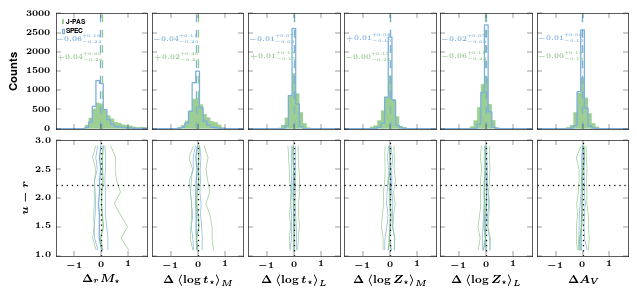

In [14]:
fig, axs = subplots(2, len(ln), figsize=(7, 3.3), sharex=True, sharey="row")

lm = xlim(-1.7, +1.7)
axs[0, 0].set_xticks([-1., 0, 1.])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    resj = err(jpas_physical[ln[j]], jpas_physical[mn[j]], rl[j])
    medj = median(resj)
    p16j, p84j = percentile(resj, [16.0, 84.0])

    resp = err(sdss_physical[ln[j]], spec_physical[mn[j]], rl[j])
    medp = median(resp)
    p16p, p84p = percentile(resp, [16.0, 84.0])
    
    if j == 0:
        if i == 0: axs[i, j].set_ylabel(r"\bf Counts")
        if i == 1: axs[i, j].set_ylabel(r"$u-r$")
    
    if i == 0:
        axs[i, j].hist(resj, 25, range=lm, histtype="step", hatch=hatching, lw=0, fc=jpas_cl, ec=jpas_cl, label=jpas_lb)
        axs[i, j].hist(resp, 25, range=lm, histtype="step", color=spec_cl, label=spec_lb)
        
        axs[i, j].axvline(median(resj), ls="--", color=jpas_cl)
        axs[i, j].axvline(median(resp), ls="--", color=spec_cl)
        
        st_textp = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$" % (medp, p16p, p84p)
        st_textj = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$" % (medj, p16j, p84j)
        axs[i, j].text(0.02, 0.75, st_textp, fontsize=tsize, color=spec_cl, ha="left", transform=axs[i, j].transAxes)
        axs[i, j].text(0.02, 0.60, st_textj, fontsize=tsize, color=jpas_cl, ha="left", transform=axs[i, j].transAxes)
    else:
        xj, yj, ej = binner(lcolor, resj, "median", 10, rang=(1, 3), ebar=True)
        xp, yp, ep = binner(lcolor, resp, "median", 10, rang=(1, 3), ebar=True)

        axs[i, j].plot(yp, xp, "-", color=spec_cl, lw=1.0)
        axs[i, j].plot(yp-ep[0], xp, "-", color=spec_cl, lw=0.5)
        axs[i, j].plot(yp+ep[1], xp, "-", color=spec_cl, lw=0.5)
        axs[i, j].plot(yj, xj, "-", color=jpas_cl, lw=1.0)
        axs[i, j].plot(yj-ej[0], xj, "-", color=jpas_cl, lw=0.5)
        axs[i, j].plot(yj+ej[1], xj, "-", color=jpas_cl, lw=0.5)
        axs[i, j].axvline(ls=":", color="k")
        axs[i, j].axhline(2.22, ls=":", color="k")
        
        axs[i, j].set_xlabel(res_lbs[j])
        axs[i, j].set_ylim(1.0, 3.0)

axs[0, 0].legend(loc=2, handlelength=0.3, handletextpad=0.3)

tight_layout()
subplots_adjust(wspace=0.05, hspace=0.1)

#savefig(od + "JPAS_vs_SPEC")

\multirow{5}{*}{$\dmass$} &     1.100 &     0.011 &     0.062 & &     0.116 &     0.013 \\
                         &     1.500 &     0.061 &     0.041 & &     0.030 &    -0.002 \\
                         &     1.900 &     0.042 &     0.003 & &    -0.012 &    -0.016 \\
                         &     2.300 &     0.061 &     0.019 & &     0.007 &     0.008 \\
                         &     2.700 &     0.031 &     0.010 & &     0.002 &    -0.008 \\
\hline
\multirow{5}{*}{$\dmwa$} &     1.100 &     0.055 &     0.060 & &     0.135 &     0.042 \\
                         &     1.500 &     0.093 &     0.078 & &     0.060 &    -0.007 \\
                         &     1.900 &     0.038 &     0.071 & &     0.004 &    -0.013 \\
                         &     2.300 &     0.105 &     0.069 & &     0.018 &     0.054 \\
                         &     2.700 &     0.062 &    -0.012 & &     0.011 &     0.016 \\
\hline
\multirow{5}{*}{$\dlwa$} &     1.100 &     0.023 &    -0.013 & &     0.146 &    -0.08

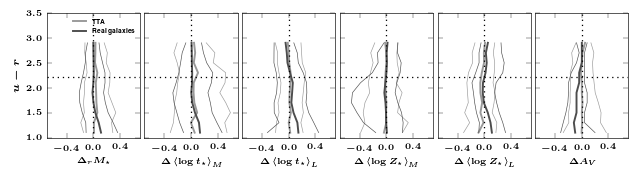

In [41]:
fig, axs = subplots(1, 6, figsize=(7, 2), sharex=True, sharey=True)

lm = xlim(-0.7, +0.7)
axs[j].set_ylim(1.0, 3.5)
axs[0].set_xticks([-0.4, 0, 0.4])

ocolor = loadtxt("ocolor.txt")

par = "$\dmass$ $\dmwa$ $\dlwa$ $\dmwz$ $\dlwz$ $\dav$".split()
kw = ["M_mod", "log_t_M_mod", "log_t_L_mod", "log_Z_M_mod", "log_Z_L_mod", "Av_mod"]
for j in xrange(axs.size):
    if j==0:
        axs[j].set_ylabel(r"$u-r$")
        res = log10(jpas_physical[mn[j]]) - log10(spec_physical[mn[j]])
    else:
        res = jpas_physical[mn[j]] - spec_physical[mn[j]]
    
    ores = loadtxt(kw[j]+".txt")
    xt, yt, et = binner(lcolor, res, "median", 10, rang=(1, 3), ebar=True)
    xo, yo, eo = binner(ocolor, ores, "median", 10, rang=(1, 3), ebar=True)

    for b in xrange(0, 10, 2):
        if b == 0:
            print r"\multirow{5}{*}{%s} &%10.3f &%10.3f &%10.3f & &%10.3f &%10.3f \\" % (par[j], xt[b], yt[b], (et[1, b]-et[0, b])*0.5, yo[b], (eo[1, b]-eo[0, b])*0.5)
        else:
            print r"                         &%10.3f &%10.3f &%10.3f & &%10.3f &%10.3f \\" % (xt[b], yt[b], (et[1, b]-et[0, b])*0.5, yo[b], (eo[1, b]-eo[0, b])*0.5)
    print r"\hline"
    
    axs[j].plot(yt, xt, "-", color="0.6", lw=1.5, label=r"\bf TTA")
    axs[j].plot(yt-et[0], xt, "-", color="0.6", lw=0.5)
    axs[j].plot(yt+et[1], xt, "-", color="0.6", lw=0.5)
    axs[j].plot(yo, xo, "-", color=gray, lw=1.5, label=r"\bf Real galaxies")
    axs[j].plot(yo-eo[0], xo, "-", color=gray, lw=0.5)
    axs[j].plot(yo+eo[1], xo, "-", color=gray, lw=0.5)
    axs[j].axvline(ls=":", color="k")
    axs[j].axhline(2.22, ls=":", color="k")
    axs[j].set_xlabel(res_lbs[j], size="small")

axs[0].legend(loc=1)

tight_layout()
subplots_adjust(wspace=0.05, hspace=0.1)

savefig(od + "JPAS_vs_SPEC")

In [ ]:
fig, axs = subplots(2, 3, figsize=(7, 4), sharex=True)
ins = inset_axes(axs[0, 2], width="65%", height="4%", loc=9)
ins.tick_params(bottom=True, top=False, direction="out")

axs[0, 0].set_xlim(-1.0, +1.0)
axs[0, 0].set_xticks(arange(-0.5, +1., 0.5))

tl = [sdss_lb, jpas_lb, spec_lb]
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])) :
    ressx = err(sdss_physical["log_t_M_lib"], sdss_physical["log_t_M_mod"], False)
    resjx = err(jpas_physical["log_t_M_lib"], jpas_physical["log_t_M_mod"], False)
    respx = err(spec_physical["log_t_M_lib"], spec_physical["log_t_M_mod"], False)
    
    if i == 0 :
        axs[i, j].set_title(tl[j])
        axs[i, j].set_ylim(-1.0, +3.0)
        axs[i, j].set_yticks(arange(-1.0, +3.5, 1.0))
        if j == 0 : axs[i, j].set_ylabel(res_lbs[0])
        
        ressy = err(sdss_physical["M_lib"], sdss_physical["M_mod"], True)
        resjy = err(jpas_physical["M_lib"], jpas_physical["M_mod"], True)
        respy = err(spec_physical["M_lib"], spec_physical["M_mod"], True)
    else :
        axs[i, j].set_ylim(-1.0, +1.0)
        if j == 0 : axs[i, j].set_ylabel(res_lbs[-3])
        if j == 1 : axs[i, j].set_xlabel(res_lbs[1])
        
        ressy = err(sdss_physical["log_Z_M_lib"], sdss_physical["log_Z_M_mod"], False)
        resjy = err(jpas_physical["log_Z_M_lib"], jpas_physical["log_Z_M_mod"], False)
        respy = err(spec_physical["log_Z_M_lib"], spec_physical["log_Z_M_mod"], False)

    ressz = err(sdss_physical["Av_lib"], sdss_physical["Av_mod"], False)
    resjz = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)
    respz = err(spec_physical["Av_lib"], spec_physical["Av_mod"], False)
    mask = (lcolor < 2.22)
    mask = ones(ressx.size, dtype=bool)
    
    if   j >  0 : axs[i, j].set_yticklabels([])
    if   j == 0 :
        sc = axs[i, j].scatter(ressx[mask], ressy[mask], s=2, lw=0, c=ressz[mask], vmin=-1.0, vmax=+1.0, cmap=map_col)
    elif j == 1 :
        sc = axs[i, j].scatter(resjx[mask], resjy[mask], s=2, lw=0, c=resjz[mask], vmin=-1.0, vmax=+1.0, cmap=map_col)
    else :
        sc = axs[i, j].scatter(respx[mask], respy[mask], s=2, lw=0, c=respz[mask], vmin=-1.0, vmax=+1.0, cmap=map_col)

    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)
    
cb = colorbar(sc, cax=ins, orientation="horizontal")
cb.set_ticks(linspace(-1.0, +1.0, 3))
cb.set_label(res_lbs[-1])

#tight_layout()
subplots_adjust(wspace=0.1, hspace=0.1)

savefig(od + "mass-age-metallicity-extinction_mw_trends")

In [ ]:
fig, axs = subplots(2, 2, figsize=(3.3, 3.3), sharex=True)
ins = inset_axes(axs[0, 1], width="65%", height="4%", loc=9)
ins.tick_params(bottom=True, top=False, direction="out")

axs[0, 0].set_xlim(-1.0, +1.0)
axs[0, 0].set_xticks(arange(-0.5, +1., 0.5))

tl = [jpas_lb, spec_lb]
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])) :
    resjx = err(jpas_physical["log_t_L_lib"], jpas_physical["log_t_L_mod"], False)
    respx = err(spec_physical["log_t_L_lib"], spec_physical["log_t_L_mod"], False)
    
    if i == 0 :
        axs[i, j].set_title(tl[j])
        axs[i, j].set_ylim(-1.0, +4.0)
        axs[i, j].set_yticks(arange(-1.0, +4.5, 1.0))
        if j == 0 : axs[i, j].set_ylabel(res_lbs[0])
        
        resjy = err(jpas_physical["M_lib"], jpas_physical["M_mod"], True)
        respy = err(spec_physical["M_lib"], spec_physical["M_mod"], True)
    else :
        axs[i, j].set_ylim(-1.0, +1.0)
        axs[i, j].set_xlabel(res_lbs[2])
        if j == 0 : axs[i, j].set_ylabel(res_lbs[-2])
        
        resjy = err(jpas_physical["log_Z_L_lib"], jpas_physical["log_Z_L_mod"], False)
        respy = err(spec_physical["log_Z_L_lib"], spec_physical["log_Z_L_mod"], False)

    resjz = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)
    respz = err(spec_physical["Av_lib"], spec_physical["Av_mod"], False)
    
    if   j >  0 : axs[i, j].set_yticklabels([])
    if j == 0 :
        sc = axs[i, j].scatter(resjx, resjy, s=2, lw=0, c=resjz, vmin=-0.5, vmax=+0.5, cmap=map_col)
    else :
        sc = axs[i, j].scatter(respx, respy, s=2, lw=0, c=respz, vmin=-0.5, vmax=+0.5, cmap=map_col)

    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)
    
cb = colorbar(sc, cax=ins, orientation="horizontal")
cb.set_ticks(linspace(-0.5, +0.5, 3))
cb.set_label(res_lbs[-1])

#tight_layout()
subplots_adjust(wspace=0.1, hspace=0.1)

savefig(od + "mass-age-metallicity-extinction_lw_trends")

In [ ]:
fig, axs = subplots(2, 3, figsize=(7, 4), sharex=True)
ins = inset_axes(axs[0, 2], width="65%", height="4%", loc=9)
ins.tick_params(bottom=True, top=False, direction="out")

axs[0, 0].set_xlim(-1.0, +1.0)
axs[0, 0].set_xticks(arange(-0.5, +1.0, 0.5))

tl = [sdss_lb, jpas_lb, spec_lb]
for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])) :
    ressx = err(sdss_physical["log_t_L_lib"], sdss_physical["log_t_L_mod"], False)
    resjx = err(jpas_physical["log_t_L_lib"], jpas_physical["log_t_L_mod"], False)
    respx = err(spec_physical["log_t_L_lib"], spec_physical["log_t_L_mod"], False)
    
    if i == 0 :
        axs[i, j].set_title(tl[j])
        axs[i, j].set_ylim(-1.0, +4.0)
        axs[i, j].set_yticks(arange(-1.0, +4.5, 1.0))
        if j == 0 : axs[i, j].set_ylabel(res_lbs[0])
        
        ressy = err(sdss_physical["M_lib"], sdss_physical["M_mod"], True)
        resjy = err(jpas_physical["M_lib"], jpas_physical["M_mod"], True)
        respy = err(spec_physical["M_lib"], spec_physical["M_mod"], True)
    else :
        axs[i, j].set_ylim(-1.0, +1.0)
        if j == 0 : axs[i, j].set_ylabel(res_lbs[-2])
        if j == 1 : axs[i, j].set_xlabel(res_lbs[2])
        
        ressy = err(sdss_physical["log_Z_L_lib"], sdss_physical["log_Z_L_mod"], False)
        resjy = err(jpas_physical["log_Z_L_lib"], jpas_physical["log_Z_L_mod"], False)
        respy = err(spec_physical["log_Z_L_lib"], spec_physical["log_Z_L_mod"], False)

    ressz = err(sdss_physical["Av_lib"], sdss_physical["Av_mod"], False)
    resjz = err(jpas_physical["Av_lib"], jpas_physical["Av_mod"], False)
    respz = err(spec_physical["Av_lib"], spec_physical["Av_mod"], False)
    mask = (lcolor < 2.22)
    mask = ones(ressx.size, dtype=bool)
    
    if   j >  0 : axs[i, j].set_yticklabels([])
    if   j == 0 :
        sc = axs[i, j].scatter(ressx[mask], ressy[mask], s=2, lw=0, c=ressz[mask], vmin=-1.0, vmax=+1.0, cmap=map_col)
    elif j == 1 :
        sc = axs[i, j].scatter(resjx[mask], resjy[mask], s=2, lw=0, c=resjz[mask], vmin=-1.0, vmax=+1.0, cmap=map_col)
    else :
        sc = axs[i, j].scatter(respx[mask], respy[mask], s=2, lw=0, c=respz[mask], vmin=-1.0, vmax=+1.0, cmap=map_col)

    axs[i, j].axvline(ls=":", color="r", lw=0.5)
    axs[i, j].axhline(ls=":", color="r", lw=0.5)
    
cb = colorbar(sc, cax=ins, orientation="horizontal")
cb.set_ticks(linspace(-1.0, +1.0, 3))
cb.set_label(res_lbs[-1])

#tight_layout()
subplots_adjust(wspace=0.1, hspace=0.1)

#savefig(od + "mass-age-metallicity-extinction_lw_trends")